In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

from urllib import urlretrieve
import cPickle as pickle
import os
import gzip

import cv2
import numpy as np
import theano

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum

from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from settings import *
from utils import *

s = Settings()

Got 29673 primary, 250 secondary ,4731 tertiary highwayframes


Got 504 train and 126 test files for label Tobi
Got 1552 train and 387 test files for label Mariam
Got 407 train and 101 test files for label Other
Got 2872 train and 718 test files for label Negative


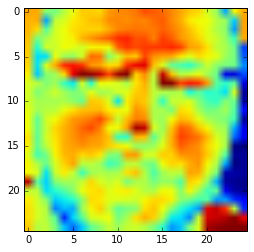

In [2]:
X_train,y_train,X_test,y_test  = load_faces(s)
plt.imshow(X_train[0][0])
plt.show()

In [4]:
net1 = s.net

# ATTENTION ! -> only if we do not want to train
net1.load_weights_from(s.net_name)
# show how this net looks like

/usr/local/lib/python2.7/dist-packages/nolearn/lasagne/base.py:734: UserWarning: The 'load_weights_from' method will be removed in nolearn 0.6. Please use 'load_params_from' instead.
  warn("The 'load_weights_from' method will be removed in nolearn 0.6. "
/usr/local/lib/python2.7/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


Loaded parameters to layer 'conv2d1' (shape 16x3x5x5).
Loaded parameters to layer 'conv2d1' (shape 16).
Loaded parameters to layer 'conv2d2' (shape 16x16x5x5).
Loaded parameters to layer 'conv2d2' (shape 16).
Loaded parameters to layer 'dense' (shape 144x151).
Loaded parameters to layer 'dense' (shape 151).
Loaded parameters to layer 'output' (shape 151x5).
Loaded parameters to layer 'output' (shape 5).


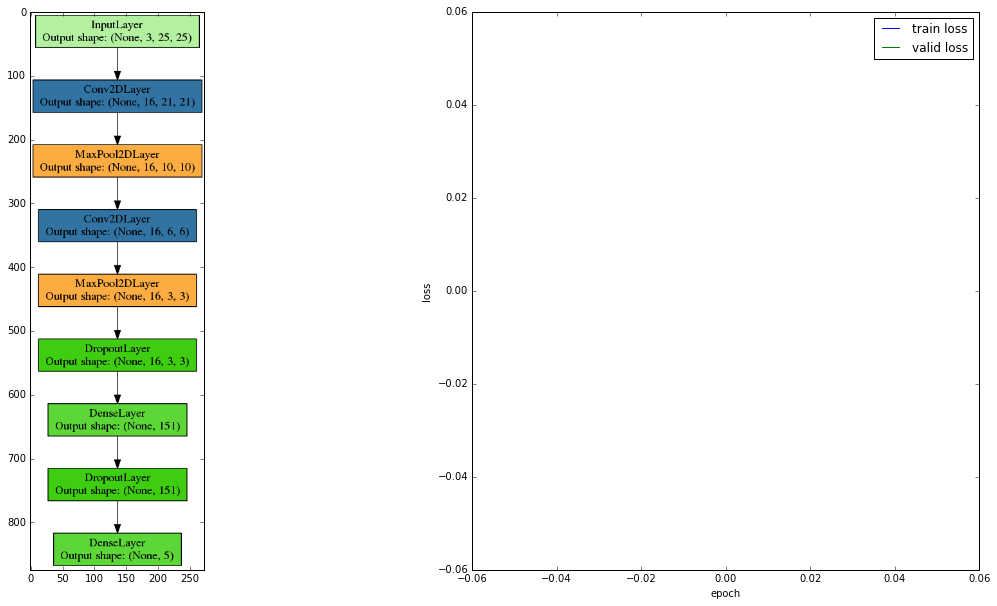

In [42]:
#nn = net1.fit(X_train, y_train)
#net1.save_weights_to('facerecognet')

# visualize
from nolearn.lasagne import visualize
from nolearn.lasagne.visualize import draw_to_notebook, draw_to_file

fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
draw_to_file(net1, "/tmp/nn_tmp.png", output_shape=True)
tmp_img = cv2.cvtColor(cv2.imread("/tmp/nn_tmp.png"), cv2.COLOR_BGR2RGB)
#img = draw_to_notebook(net1, output_shape=True)
plt.imshow(tmp_img)
fig.add_subplot(122)
visualize.plot_loss(net1)
fig.savefig("test.png")

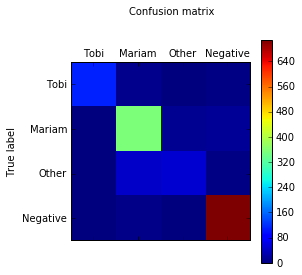

In [69]:
preds = net1.predict(X_test)

cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.suptitle('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.yticks(range(len(s.labels)), s.labels)
plt.xticks(range(len(s.labels)), s.labels)
plt.show()

Shape of conv2d1 layer weights:  (16, 3, 5, 5)


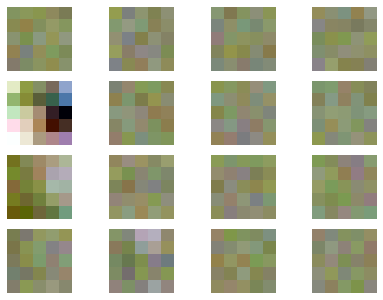

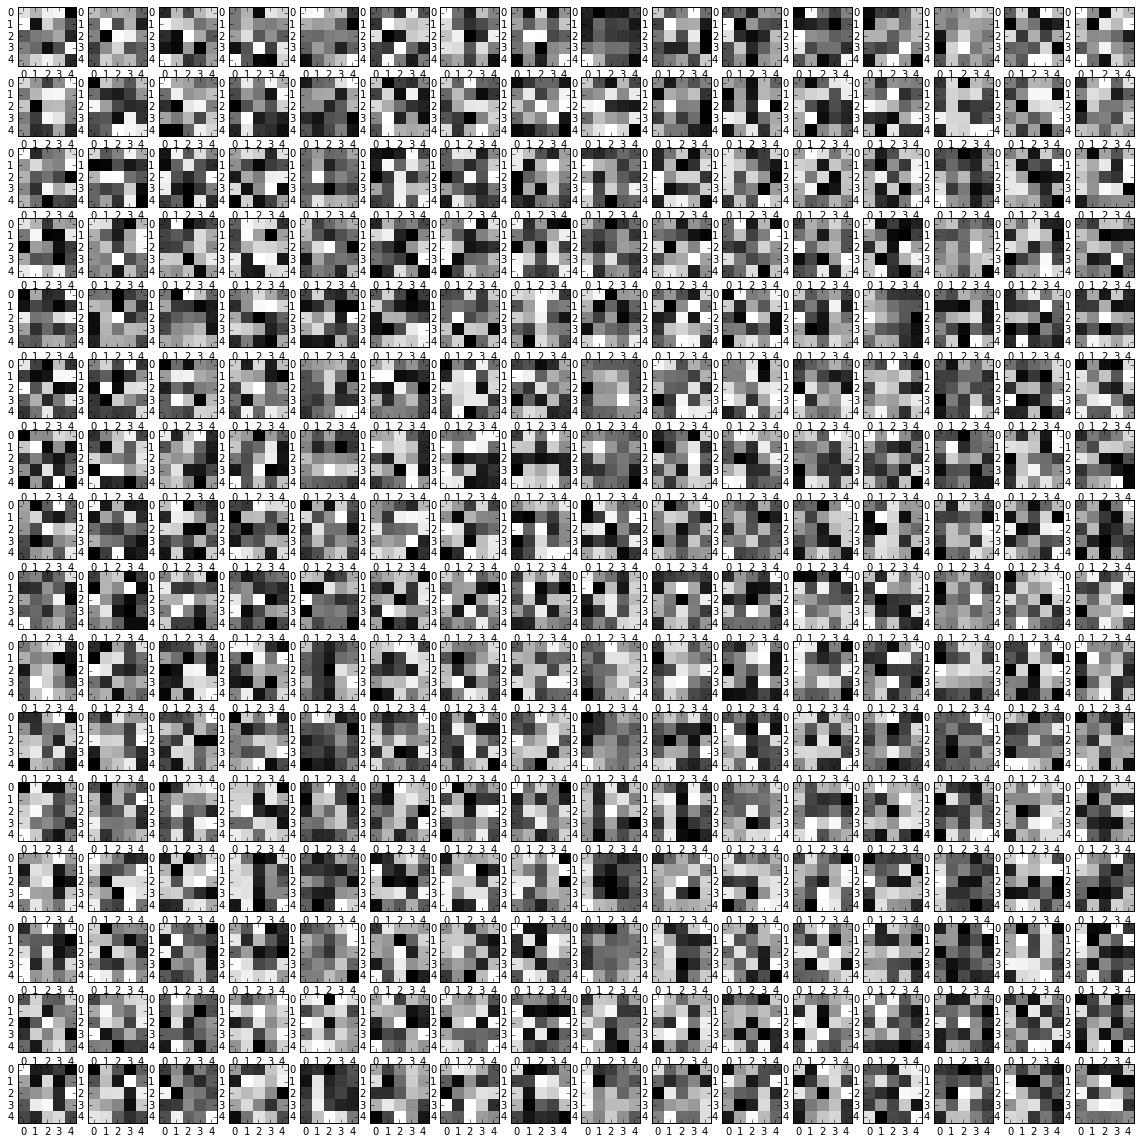

In [68]:
from matplotlib import pyplot as plt
import numpy as np


def make_conv_map(conv_weights,global_scale=False):
    shape = conv_weights.shape
    nrows = np.ceil(np.sqrt(shape[0])).astype(int)
    ncols = nrows
    fig, axes = plt.subplots(nrows, ncols)

    if global_scale:
        wmin,wmax = np.min(conv_weights,(0,2,3)),np.max(conv_weights,(0,2,3)) #seperate min and max per channel

    for i,ax in enumerate(axes.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        if i < shape[0]:
            w = conv_weights[i]
            if w.shape[0] > 3:
                w = np.sum(w, axis=0)[np.newaxis,:,:]
            w=np.squeeze(w.transpose(1,2,0))

            if not global_scale:
                wmin,wmax = np.min(w,(0,1)), np.max(w,(0,1)) #seperate min and max per channel

            w -= wmin
            w /= (wmax-wmin)
            ax.imshow(cv2.cvtColor(w, cv2.COLOR_BGR2RGB), interpolation='nearest', cmap='gray')
    fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=1)
    return fig, axes

# show layer weights
fig = plt.figure(figsize=(20,20))
fig,axes = make_conv_map(net1.layers_['conv2d1'].W.get_value(), True)
print "Shape of conv2d1 layer weights: ", net1.layers_['conv2d1'].W.get_value().shape
plt.show()

fig = plt.figure(figsize=(20,20))
for j in range(net1.layers_['conv2d2'].W.get_value().shape[0]):
    values = net1.layers_['conv2d2'].W.get_value()[j]
    for i in range(len(values)):
        fig.add_subplot(net1.layers_['conv2d2'].W.get_value().shape[0],16,(j*16)+1+i)
        #ax.grid()
        #ax.set_xticks([])
        #ax.set_yticks([])
        plt.imshow(values[i], interpolation='nearest', cmap='gray')
plt.show()

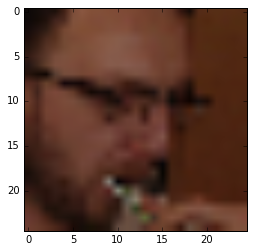

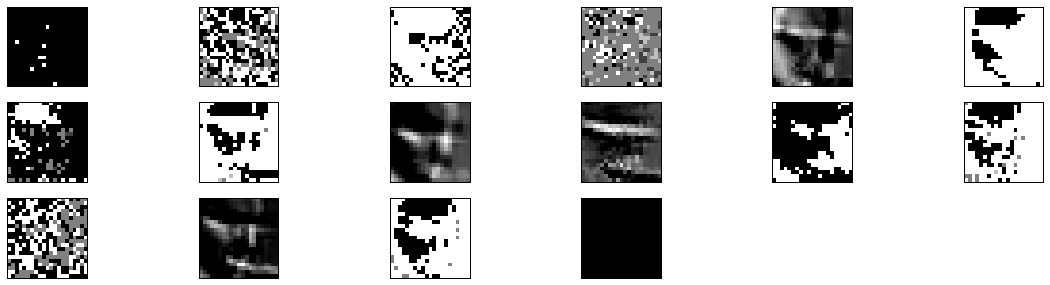

In [40]:
layers = net1.get_all_layers()
layer = layers[1]

fig = plt.figure()
plt.imshow(cv2.cvtColor(X_test[12:13][0].transpose(1,2,0).reshape(s.img_size, s.img_size,3), cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(20,10))
output = layer.get_output_for(X_test[12:13]).eval()[0]
gs = gridspec.GridSpec(6, 6)
for i in range(layer.num_filters):
    g = gs[i]
    ax = plt.subplot(g)
    ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(output[i], interpolation='nearest', cmap='gray')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


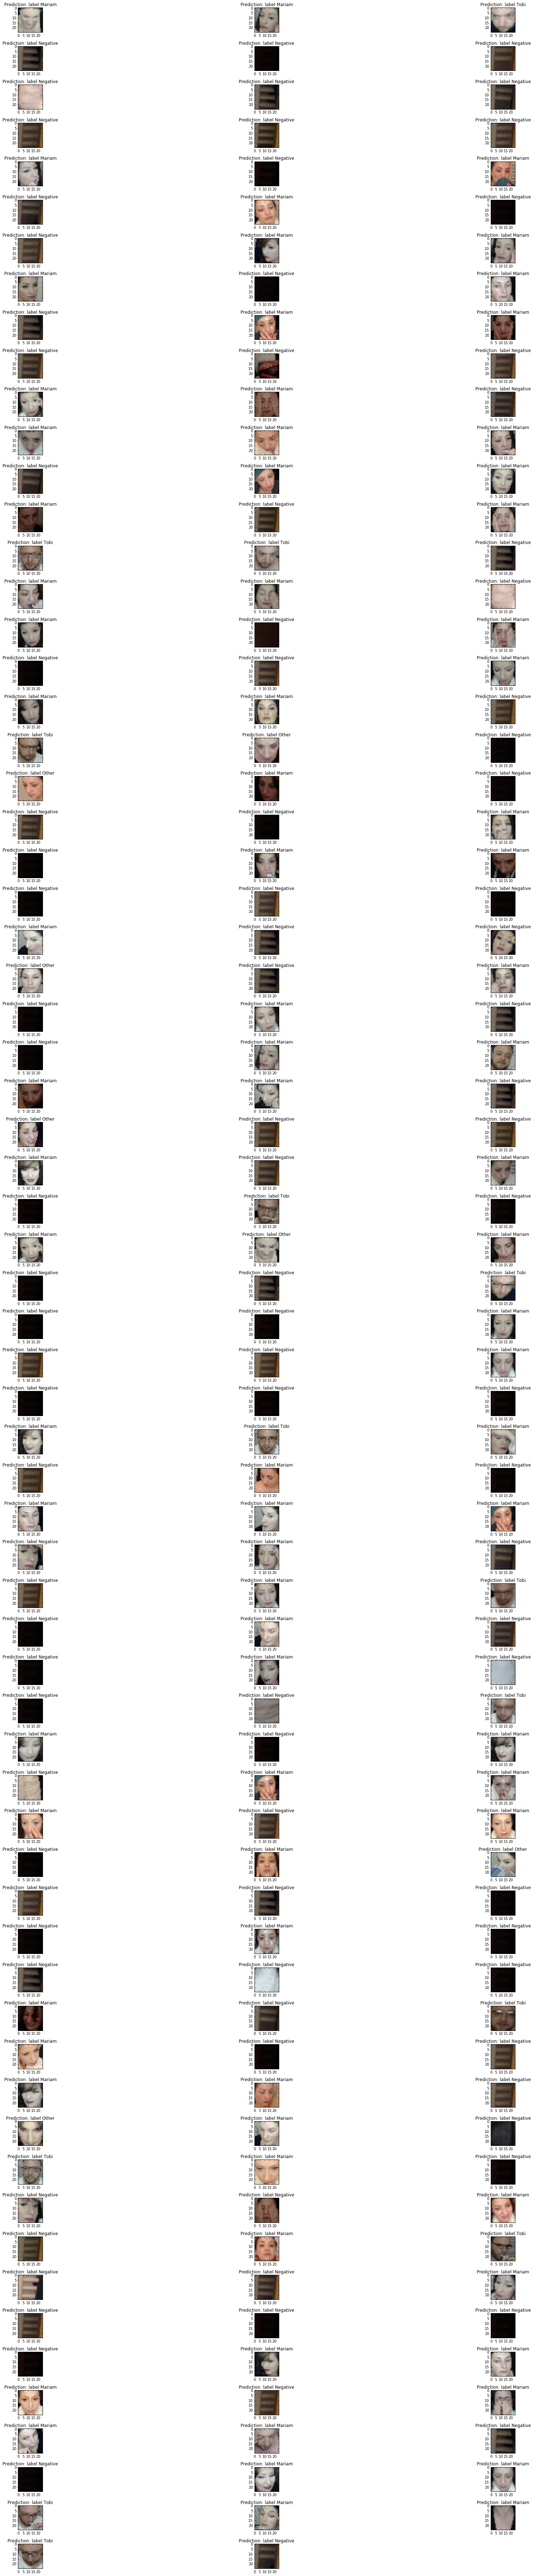

In [41]:
# predict some specific faces and show the labels
import math
fig = plt.figure(figsize=(30,100))
nimages = 200
cols = 3
rows = math.ceil(nimages / float(cols))

for i in range(1,nimages+1):
    fig.add_subplot(rows,cols,i)
    query_img = X_test[np.random.randint(len(X_test))]
    pred = net1.predict(np.array(np.array([query_img])))
    plt.title("Prediction: label %s" % s.labels[pred])
    plt.imshow(cv2.cvtColor(query_img.transpose(1,2,0).reshape(s.img_size, s.img_size,3), cv2.COLOR_BGR2RGB))
plt.tight_layout()

In [11]:
# measure how fast one forward-run (a prediction) is
import time
times = np.empty((0,1), np.float64)
for i in range(100):
    query_img = X_test[i]
    st = time.time()
    pred = net1.predict(np.array(np.array([query_img])))
    t = time.time() - st
    times = np.append(times, np.array([[t]]), axis=0)
print "Average time per prediciton: ", np.mean(times, axis=0)
print "That would give us %f fps" % (1. / np.mean(times, axis=0))
    

Average time per prediciton:  [ 0.00062633]
That would give us 1596.595395 fps


In [12]:
# now check everything with resizing and shuffling channels etc
# take images from arbitrary label
files = glob.glob("./faces_120/Tobi/*.png")
times = np.empty((0,1), np.float64)
for f in files:
    st = time.time()
    img = cv2.resize(cv2.imread(f)/255., (s.img_size, s.img_size))
    img = img.transpose(2,0,1).reshape(3,s.img_size,s.img_size).astype(np.float32)
    net1.predict(np.array(np.array([img])))
    t = time.time() - st
    times = np.append(times, np.array([[t]]), axis=0)
print "Average time per prediciton: ", np.mean(times, axis=0)
print "That would give us %f fps" % (1. / np.mean(times, axis=0))

Average time per prediciton:  [ 0.00268892]
That would give us 371.897004 fps
